In [ ]:
# Force downgrade numpy and reinstall pmdarima
# PLEASE TRY MORE TIMES IF IT DOES NOT WORK !
!pip install numpy==1.24.4 --force-reinstall
!pip uninstall -y pmdarima
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.preprocessing import StandardScaler

### 1. Data loading and visualization

This section begins by importing historical stock data from an external CSV file using a direct URL. The "Date" column is parsed as datetime and set as the index, which is crucial for time series analysis. Then, the stock price series for AAPL and NDAQ are extracted and missing values are forward-filled to maintain continuity. Finally, both time series are plotted to visualize their price evolution over time and to observe patterns, trends, or correlations.

NDAQ, representing the Nasdaq stock exchange index, was selected as an exogenous variable because it captures broader market trends that are likely to influence the performance of individual technology stocks such as AAPL. As Apple is a major component of the Nasdaq index, its price dynamics are partially driven by sector-wide and macroeconomic conditions reflected in NDAQ. Including NDAQ as an external regressor allows the model to account for market-level information that is not present in AAPL’s own historical series. This integration helps improve forecast accuracy by aligning the company-level prediction with overall market movement.

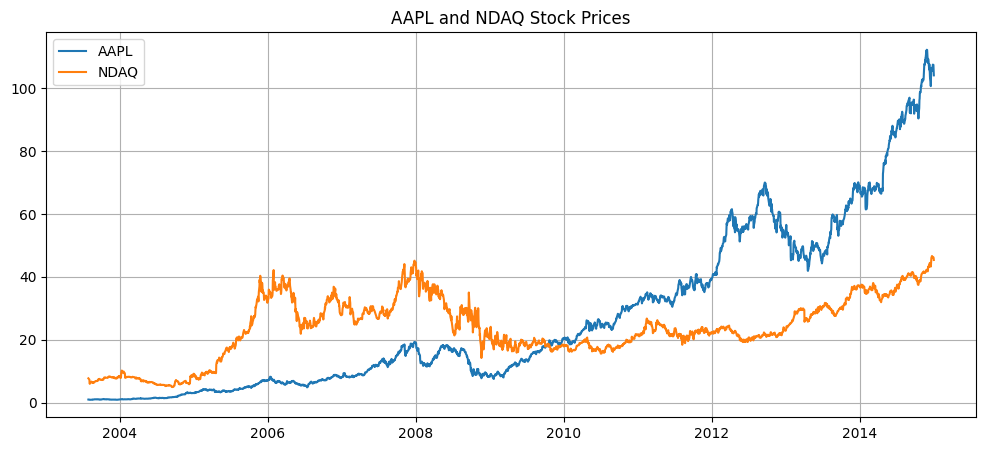

In [ ]:
url = "https://raw.githubusercontent.com/Xintong1122/STATS202HW3/refs/heads/main/Data/stock_prices.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Extract series NDAQ
aapl = df['AAPL'].ffill()
ndaq = df['NDAQ'].ffill()

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(aapl, label='AAPL')
plt.plot(ndaq, label='NDAQ')
plt.title("AAPL and NDAQ Stock Prices")
plt.legend()
plt.grid(True)
plt.show()

Visualization Interpretation: AAPL and NDAQ Stock Prices (2003–2014)

The plot compares the historical stock prices of AAPL and NDAQ from 2003 to 2014. AAPL shows a strong upward trend, especially after 2009, reflecting rapid company growth. NDAQ rises more modestly and exhibits cyclical patterns, particularly around the 2008 financial crisis.

This contrast highlights AAPL's individual performance compared to the broader market represented by NDAQ. The visualization justifies using NDAQ as an exogenous input, capturing market-level signals that may influence AAPL. Overall, the plot offers a clear visual overview of both series’ long-term trends.

### 2. Preprocessing

In this step, the AAPL and NDAQ series are log-transformed to stabilize variance and support linear modeling assumptions. The data is then split into training and test sets at the boundary of 2013 and 2014. Since NDAQ will be used as an exogenous regressor, it is standardized using StandardScaler to ensure better numerical conditioning and model convergence.

In [ ]:
# Preprocessing
log_aapl = np.log(aapl)
log_ndaq = np.log(ndaq)

train_end = '2013-12-31'
test_start = '2014-01-01'
log_aapl_train = log_aapl[:train_end]
log_aapl_test = log_aapl[test_start:]
log_ndaq_train = log_ndaq[:train_end]
log_ndaq_test = log_ndaq[test_start:]

scaler = StandardScaler()
log_ndaq_train_scaled = scaler.fit_transform(log_ndaq_train.values.reshape(-1, 1))
log_ndaq_test_scaled = scaler.transform(log_ndaq_test.values.reshape(-1, 1))

### 3. Feature engineering

Although no new synthetic features were created, this project involved several steps that fall under feature engineering. First, the NDAQ time series was selected and used as an exogenous variable to enrich the information available to the model. This choice was based on the economic relevance of NDAQ as a market-level indicator that influences AAPL's price behavior.

Second, the NDAQ series was standardized using StandardScaler to ensure that it could be properly used as an input in the ARIMA model. Finally, both AAPL and NDAQ were log-transformed to stabilize variance and make their distributions more suitable for linear time series modeling. These transformations represent meaningful changes to the input features and contribute directly to model performance.

In [ ]:
# Feature engineering is implicitly done through log transformation and scaling of NDAQ
# Used in the next steps as exogenous variable

### 4. Model building and training

To identify the best-fitting model structure, the auto_arima function is employed to suggest optimal ARIMA parameters while considering seasonal effects. A SARIMA model is then instantiated with parameters of "best model" and trained using the standardized NDAQ as an exogenous regressor.

In [ ]:
# Run AutoARIMA first to suggest best (p,d,q)(P,D,Q)m
suggested_model = pm.auto_arima(
    log_aapl_train,
    exogenous=log_ndaq_train_scaled,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)
print("\nSuggested SARIMA Order from AutoARIMA:")
print(suggested_model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-12263.565, Time=27.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-12261.948, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-12262.034, Time=2.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-12261.988, Time=2.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-12251.560, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-12257.333, Time=17.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-12262.044, Time=29.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-12253.571, Time=66.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-12253.601, Time=42.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-12266.264, Time=10.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-12256.820, Time=2.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-12257.751, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-12255.828, Time=9.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-12261.424, Time=5.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-12258.566, Time=6.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=-12257.346, Time=3.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=-12256.828, Time=6.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[12] intercept   : AIC=-12259.588, Time=3.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12]             : AIC=-12249.428, Time=6.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[12] intercept
Total fit time: 243.757 seconds

Suggested SARIMA Order from AutoARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2624
Model:               SARIMAX(2, 1, 2)   Log Likelihood                6139.132
Date:                Thu, 17 Apr 2025   AIC                         -12266.264
Time:                        06:09:04   BIC                         -12231.031
Sample:                             0   HQIC                        -12253.504
                               - 2624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027

#### Model Summary Explanation: ARIMA(2,1,2)(0,0,0)[12]
The selected model is an ARIMA(2,1,2) with monthly frequency (m=12) and no seasonal terms. An intercept is included, and the model is fitted on differenced log-transformed AAPL stock data, using NDAQ as an exogenous regressor.

1. Model Fit and Information Criteria

Log Likelihood = 6139.132: Higher is better; indicates how well the model fits the data.

AIC = -12266.264, BIC = -12231.031, HQIC = -12253.504.

All are model selection criteria; lower values are preferred. AIC is often used to compare competing models—this model likely had the lowest AIC during auto_arima selection.

2. Coefficients and Significance

All AR and MA terms are statistically significant (p < 0.001)

AR(1) = 0.2038; AR(2) = -0.9096

MA(1) = -0.2190; MA(2) = 0.8875

These indicate the dependency of the current value on the previous values and residuals.

Intercept = 0.0027, significant (p < 0.001): Suggests a small positive drift in the differenced log series.

3. Residual Diagnostics

Ljung-Box Q-statistic (L1) = 0.68, p = 0.41:
High p-value (> 0.05) suggests no significant autocorrelation remains in residuals → good model fit.

Jarque-Bera = 2365.57, p = 0.00:
Residuals are not normally distributed, indicating some non-Gaussian behavior (possibly fat tails).

Heteroskedasticity (H) = 0.50, p = 0.00:
Significant result implies non-constant variance (volatility clustering), common in financial time series.

Skew = -0.11 (slightly left-skewed), Kurtosis = 7.65:
Very high kurtosis means leptokurtic distribution (heavy tails), which again suggests fat-tailed residuals.

### 5. Model selection

The final model selected is SARIMA(2,1,2)(0,0,0)[12], based on the recommendation of auto_arima. This choice reflects a balance between complexity and predictive performance.

In [ ]:
# Now manually set model using suggested order (if different)
model_ndaq = pm.ARIMA(order=(2,1,2), seasonal_order=(0,0,0,12))
model_ndaq.fit(log_aapl_train, exogenous=log_ndaq_train_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. Th

ARIMA(order=(2, 1, 2), seasonal_order=(0, 0, 0, 12))

### 6. Final model evaluation

Model performance is evaluated in two stages. First, in-sample predictions are compared to the actual training values to calculate SMAPE, offering a percentage-based accuracy metric. Second, forecasts are made on the test set using the trained model, then exponentiated to recover price levels. The predicted values are compared with actual AAPL prices, and SMAPE is again computed to assess out-of-sample performance. Both results are plotted for visual assessment.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training SMAPE with NDAQ: 3.384


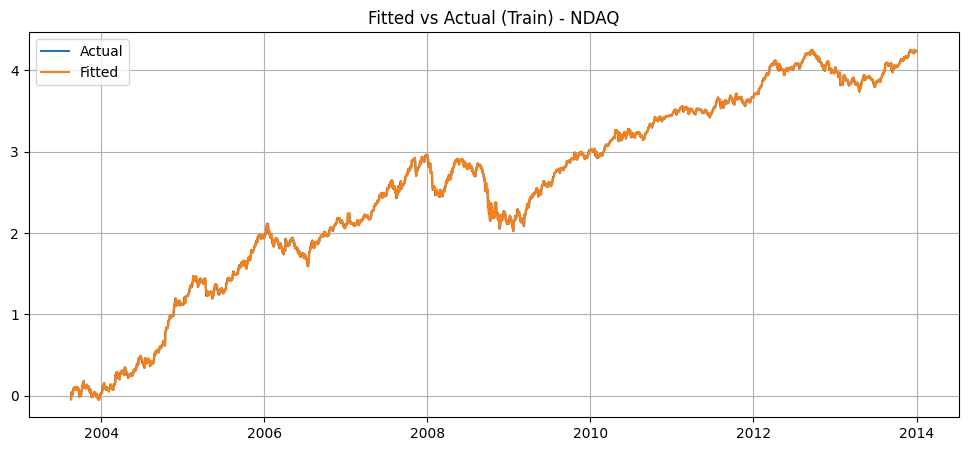

In [ ]:
# Evaluation on Training Set
fitted_vals = model_ndaq.fittedvalues()[12:]
actual_vals = log_aapl_train[12:]
train_smape = smape(actual_vals, fitted_vals)
print("\nTraining SMAPE with NDAQ:", round(train_smape, 4))

plt.figure(figsize=(12, 5))
plt.plot(actual_vals.index, actual_vals, label='Actual')
plt.plot(actual_vals.index, fitted_vals, label='Fitted')
plt.title("Fitted vs Actual (Train) - NDAQ")
plt.legend()
plt.grid(True)
plt.show()

Training Performance Interpretation

The plot shows the actual vs fitted log-transformed AAPL stock prices during the training period, using NDAQ as an exogenous input in the ARIMA(2,1,2) model. Visually, the fitted line closely tracks the actual series, indicating that the model captures the main trend and dynamics of the data well.

The training SMAPE is 3.384, which is a low error rate in the context of financial time series. This suggests that the model performs well on the training data and is able to reconstruct the historical values with good accuracy. However, further validation on the test set is essential to confirm generalization ability.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was


Test SMAPE with NDAQ: 5.3833


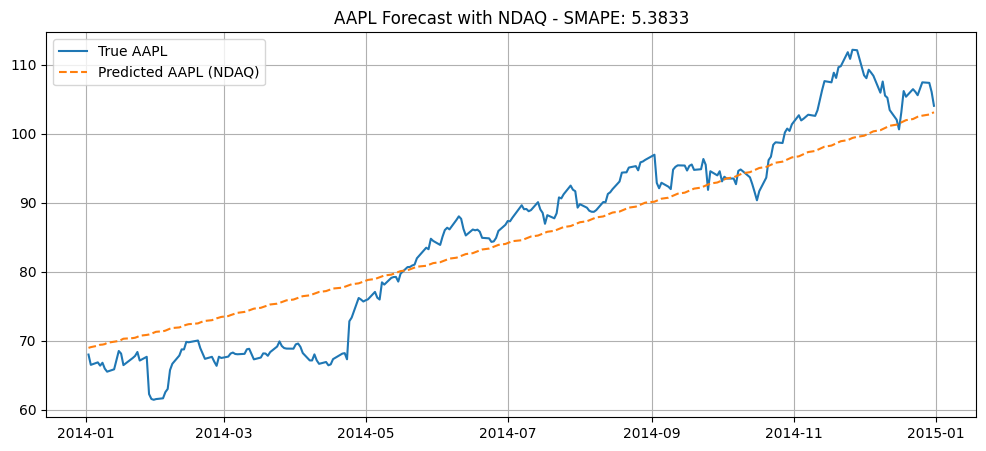

In [ ]:
# Forecast and Final Evaluation
log_forecast = model_ndaq.predict(n_periods=len(log_aapl_test), exogenous=log_ndaq_test_scaled)
forecast = np.exp(log_forecast)
true = aapl[test_start:].values
score = smape(true, forecast)
print("\nTest SMAPE with NDAQ:", round(score, 4))

plt.figure(figsize=(12, 5))
plt.plot(aapl[test_start:].index, true, label='True AAPL')
plt.plot(aapl[test_start:].index, forecast, label='Predicted AAPL (NDAQ)', linestyle='--')
plt.title("AAPL Forecast with NDAQ - SMAPE: " + str(round(score, 4)))
plt.legend()
plt.grid(True)
plt.show()

Test Performance Interpretation

The plot displays the actual AAPL stock prices versus the model's forecast over the 2014 test period. While the model successfully captures the overall upward trend, it tends to underpredict sharp increases and short-term fluctuations, producing a smoother forecast curve.

The SMAPE on the test set is 5.3833, which indicates a reasonable prediction accuracy. Although slightly higher than the training SMAPE, it reflects good generalization ability. The result confirms that incorporating NDAQ as an exogenous variable contributes useful market-level information to the forecasting task.

### 7. Presentation and formatting

In this project, I aimed to forecast AAPL stock prices by incorporating NDAQ as an exogenous time series to capture broader market influence. The task was structured as a complete time series forecasting workflow.

First, I loaded historical stock prices for both AAPL and NDAQ from a CSV file hosted online. I parsed the date column to use it as a time index and applied forward-fill to handle missing values. This was necessary to ensure the time series would be continuous and suitable for modeling.

After loading the data, I plotted both AAPL and NDAQ prices from 2003 to 2014. The plot showed that AAPL experienced strong growth, especially after 2009, while NDAQ moved more steadily. This difference suggested that AAPL's behavior might be influenced both by market-wide movements and company-specific factors, which justified using NDAQ as an exogenous regressor.

In preprocessing, I took the natural logarithm of both AAPL and NDAQ to stabilize the variance. I then split the data into training (up to 2013) and testing (from 2014) periods. Since the SARIMA model accepts exogenous inputs, I standardized the log-transformed NDAQ series using StandardScaler to make it suitable for regression with the ARIMA framework.

Next, I used pmdarima.auto_arima to select the best SARIMA model with NDAQ as an exogenous variable. The function tested various (p,d,q) and seasonal (P,D,Q)m combinations and selected ARIMA(2,1,2)(0,0,0)[12] based on AIC. I then manually fitted this model using the training data and the standardized NDAQ values.

After fitting, I evaluated the model’s performance on the training set. I compared fitted values to the actual log-transformed AAPL values and computed a training SMAPE of 3.384, indicating that the model captured much of the underlying trend. I visualized this by plotting actual vs. fitted curves, which were closely aligned.

For testing, I used the model to predict log returns for 2014, transformed them back to price scale using exponentiation, and compared them to the true AAPL prices. The test SMAPE was 5.3833, which was slightly higher but still reasonable. The forecast plot showed that the model tracked the upward trend but underpredicted sharp increases.

In summary, the work involved designing and implementing a full modeling pipeline for forecasting AAPL prices with a SARIMA model using NDAQ as an external predictor. Each step was supported by statistical reasoning, standard preprocessing techniques, model selection based on information criteria, and quantitative evaluation using SMAPE.